# Conformalization on Segmentation Contours: WBC dataset

- Author: Luca Mossina. IRT Saint Exupéry, Toulouse, France

**Scope**: test the full pipeline for Conformal Prediction on WBC datasets (universeg predictor)

- data: wbc
- predictor: universeg
- nonconformity score: thresholding, n. of dilations, radius of structuring element

Additional material:
- Mathematical morphology [wikipedia](*https://en.wikipedia.org/wiki/Mathematical_morphology)

In [1]:
import os
from dotenv import load_dotenv
import torch
import matplotlib.pyplot as plt

from benchmarkerie.datasets import make_universeg_predictions, setup_wbc

from consema.conformal import Conformalizer
from consema.plots import visualize_false_negatives
from consema.morphology import (
    dilation_metrics,
)
from consema.conformal import thresholding_score
from consema.plots import plot_margin_and_recovered, visualize_false_negatives
from consema.morphology import (
    dilation_score_variable_disk,
    dilation_score_fixed_disk,
)
from consema.morphology import (
    operator_dilation_sequential,
    operator_dilation_disk_radius,
)

from universeg import universeg  # installed via Makefile

model = universeg(pretrained=True)

GPUNAME = "cuda:0"
device_str = GPUNAME if torch.cuda.is_available() else "cpu"
device = torch.device(device_str)

_ = model.to(device)

# RANDOM_SEED = 1
RANDOM_SEED = 42

## Setup data, predictors and predictions

In [2]:
LABEL = "nucleus"
# LABEL = "cytoplasm"

## high performance predictor
# n_support_samples = 48
## medium performance predictor
n_support_samples = 24
# ## lower performance predictor
# n_support_samples = 12

data_support, data_calib, data_test, support_images, support_labels = setup_wbc(
    LABEL,
    n_support_samples,
    random_seed=RANDOM_SEED,
    device=device_str,
)

LOAD_PREDS = False
SAVE_PREDS = False

if SAVE_PREDS:
    load_dotenv()
    PREDS_DIR = os.getenv("EXPERIMENTS_DIR", "experiments")
else:
    PREDS_DIR = None

    import numpy as np

if LOAD_PREDS:
    load_dotenv()
    PREDS_DIR = os.getenv("EXPERIMENTS_DIR", "experiments")
    # Load predictions for calibration and test datasets
    calib_preds = np.load(f"{PREDS_DIR}/calib_nsup_{n_support_samples}.npz")
    # test_preds = np.load(f"{PREDS_DIR}/test.npz")

    calib_images = calib_preds["images"]
    calib_gt_masks = calib_preds["gt_masks"]
    calib_predictions = calib_preds["preds"]

    # test_images = test_preds['images']
    # test_gt_masks = test_preds['gt_masks']
    # test_predictions = test_preds['preds']

    print("Calibration predictions loaded.")
    print("Test predictions loaded.")

# # Save predictions for calibration and test datasets in single files
calib_images, calib_gt_masks, calib_predictions = make_universeg_predictions(
    data_calib,
    f"calib_nsup_{n_support_samples}",
    device_str=device_str,
    support_images=support_images,
    support_labels=support_labels,
    universeg_model=model,
    save_to=PREDS_DIR,
)
# make_universeg_predictions(data_test, "test", save_to=PREDS_DIR)

### Visualize False Negatives: we want to control their quantity

Via conformal prediction, we control how many false negative we will have, on average, in our test inferences (e.g. when deployed in production)

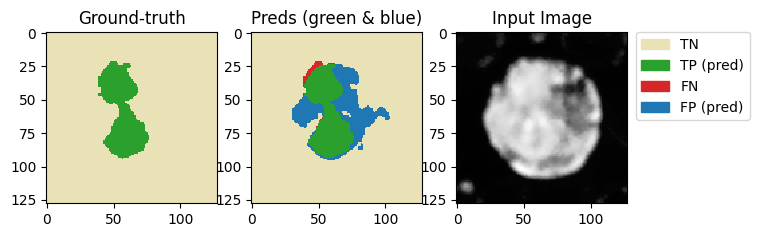

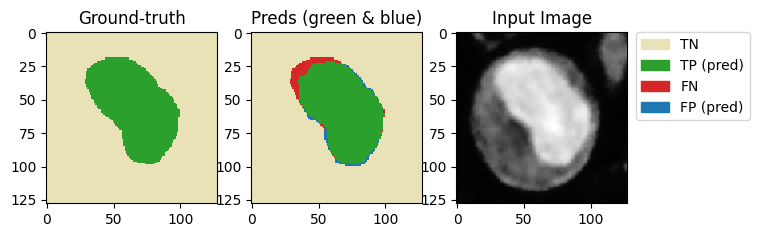

In [3]:
for it, (image, prediction, gt) in enumerate(
    zip(calib_images, calib_predictions, calib_gt_masks)
):
    if it >= 2:
        break
    visualize_false_negatives(image[0], gt[0], prediction[0] > 0.5)

In the figure above, the **red points** are false negatives, that is, points that belong to the ground-truth masks but were not predicted by the algorithm.

Using conformal prediction, we want to "extend" the prediction area (in green) with a conformal margin so that we limit our prediction errors, that is, we reduce the number of false negative with high probability at a significance level chosen by the user.

The price to pay are more false positives: in this case, we can imagine that false positives push the users to be more conservative and they are "safe" errors.

If there are too many false positives, then the prediction becomes operationally useless; this tradeoff is controlled by the user and their predictive model: worse models will have more false negatives, hence larger conformal margins. 

## Nonconformity scores as held-out errors

Conformal prediction provides a prediction sets that, on average, is statistically valid at a confidence level set by the user.
Concretely, the standard approach is known as "split conformal prediction", where a part the training data is held out exclusively to compute **prediction errors known as nonconformity scores**: for each application (classification, regression, etc.) one can find several proposition in the literature.

The idea is then to use **held-out data to estimate the errors made in production** (e.g. as computed on the test set) and build a prediction set that contains the ground-truth at a specified confidence level, in a frequentist manner.

The interest of CP is getting statistical guarantees on the prediction sets with little hypotheses: the data being exchangeable (or i.i.d.), which implies the errors (i.e. the nonconformity scores) to be exchangeable.

The guarantees are:
- distribution-free (no hypotheses on the underlying probability distribution of the data)
- model-agnostic
- finite-sample, that is, non-asymptotic.

CP is not the only approach to build prediction sets: e.g. parametric models from the statistics literature  (linear models with gaussian homoskedastic errors).

If one is not interested in these theoretical guarantees (distribution-free, finite-sample, model-agnostic) but only in an empirical measure of uncertainty, this process can be done on training data itself: if the ML predictor does not overfit too much and the errors (i.e. scores) are similar to what one has in production, the "conformal" prediction sets will be reasonably good (but they may not be large enough to be valid at the specified level).

### Formal definition

In this repo, we use the generic formulation of **nested** prediction sets as introduced by [Gupta et al. (2019)](https://www.sciencedirect.com/science/article/abs/pii/S0031320321006725) [(arXiv)](https://arxiv.org/abs/1910.10562).
They show how this can be directly linked to an underlying nonconformity score.

An example of nested prediction set:
$$
C_{\lambda}(X) := [ f(x) - \lambda, f(x) + \lambda ]
$$

The nonconformity score, for a sample $(X_i, Y_i)$:

$$
\widehat{\lambda} = \text{inf} \{\lambda \in \Lambda: Y_i \in  C_{\lambda}(X)\}
$$

In words, the nonconformity score is the smallest parameter value such that the prediction set contains the true value $Y_i$.
In regression, this boils down to a simple interval.


In our case of binary image segmentation, this is extended to sets of points in a discrete space $\mathcal{Y} \subseteq \{0,1\}^{H \times W}$

$$
\widehat{\lambda} = \text{inf} \{\lambda \in \Lambda: Y_i \subseteq  C_{\lambda}(X)\}
$$

In words, the nonconformity score is the smallest parameter value such that the extended prediction mask contains all the pixel of the ground-truth mask.
Later, we implement a more permission version where only a fraction $\tau \in [0,1]$ suffice to consider the truth to be covered (e.g. 99% of the pixel in the gt mask).

In [4]:
# idx_ = 0
# idx_ = 1
# idx_ = 2 ## good visual example
# idx_ = 3
idx_ = 12
# idx_ = 10
bintruth = calib_gt_masks[idx_] > 0.5
binpred = calib_predictions[idx_] > 0.5
softpred = calib_predictions[idx_]

cov_threshold = 0.999

### Thresholding nonconformity score

Sources:
- LAC (Least Ambiguous Set-Valued Classifiers), [Sadinle et al. (2019)](https://arxiv.org/abs/1609.00451)
- CRC (Conformal Risk Control), [Angelopoulos et al. (2022)](https://arxiv.org/abs/2208.02814)

**Thresholding the softmax** or sigmoid scores for **classification** follows from the theory developed in Sadinle et al. (2019), where they work with generic probability distribution, not specifically with neural networks. In this case, the probability estimates (e.g. softmax scores) are known to be not calibrated, and some properties (e.g. optimal size of prediction sets) do not necessarily hold. 

As for **binary image segmentation** with an underlying pixel-wise classifier, this was introduced as an application of their CRC algorithm by Angelopoulos et al. (2022): they do not explicitly mention nonconformity scores, although it follows immediately from their definition of risk and computation of $\hat{\lambda}$, for the case of binary (conformal) losses.

In [5]:
nc_threshold, dilated_threshold_mask = thresholding_score(
    gt_mask_=bintruth,
    soft_pred_mask_=softpred,
    # se_params_=se_params,
    coverage_threshold=cov_threshold,
)

print(f"{nc_threshold = :.9f}")
metrics = dilation_metrics(dilated_threshold_mask[0], binpred[0])
print(f" --- THRESH: n. added px = {metrics[0]}, stretch = {metrics[1]}")

coverage_tensor = np.multiply(dilated_threshold_mask, bintruth)
coverage = np.sum(coverage_tensor) / np.count_nonzero(bintruth)
print(f"{coverage = :.9f}")

nc_threshold = 0.896131691
 --- THRESH: n. added px = 403, stretch = 1.2355347749853887
coverage = 0.999439462


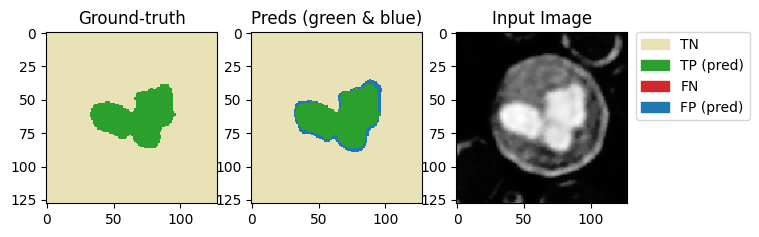

In [6]:
visualize_false_negatives(calib_images[idx_][0], bintruth[0], dilated_threshold_mask[0])

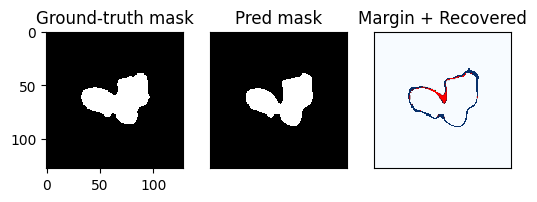

In [7]:
plot_margin_and_recovered(
    binpred[0],
    bintruth[0],
    dilated_threshold_mask[0],
    plot_hard_margin=False,
    figsize=(6, 3),
)

### Morphological prediction sets: dilation

This is part of the original contribution of the paper: building statistically valid prediction sets under minimal information.
- No softmax/sigmoid scores necessary
- usable on blackbox predictor, e.g. hidden behind API, MLaaS, etc.
- only need a small dataset of labeled, production-like data to measure uncertainty
- literature available: mathematical morphology for computer vision (without deep learning)

I introduce two cases:
- (3x3) structuring element, either square or cross: iteratively dilate the mask as dilated at previous iterations until $\tau \times 100 \%$ of the ground-truth pixels are recovered. Applying several dilations (or other) is also known as **depth** of the dilation. This will constitue the nonconformity score, the higher the worse the prediction was.
- variable-size disk: as above, but only apply one dilation to the predicted mask, with the radius of the disk increasing at each iteration

In [8]:
se_params = dict(strict_radius=True)  # [3 X 3] cross
# se_params = dict(strict_radius=False)  # [3 X 3] square

#### Iterative dilations

Nonconcormity score = depth, or number of repeated dilations.
- Using fixed-size structuring element

nc_fixed = 4
 ---  FIXED: n. added px = 778, stretch = 1.4547048509643483


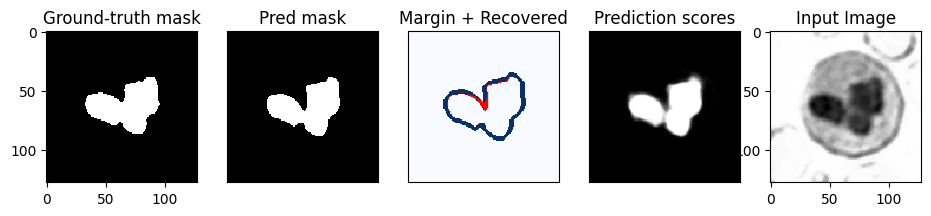

In [9]:
## 1. Fixed disk
nc_fixed = dilation_score_fixed_disk(
    gt_mask_=bintruth[0],
    pred_mask_=binpred[0],
    se_params_=se_params,
    coverage_threshold=cov_threshold,
)
print(f"{nc_fixed = }")


dilated_mask_fixed = operator_dilation_sequential(
    input_mask=binpred[0], operator_parameter=nc_fixed, se_params_=se_params
)

metrics = dilation_metrics(dilated_mask_fixed, binpred[0])
print(f" ---  FIXED: n. added px = {metrics[0]}, stretch = {metrics[1]}")

plot_margin_and_recovered(
    binpred[0],
    bintruth[0],
    dilated_mask_fixed,
    input_image=calib_images[idx_][0],
    softprediction=softpred[0],
)
# visualize_false_negatives(calib_images[idx_][0], bintruth[0], dilated_mask_fixed)

Figure with color scheme for paper

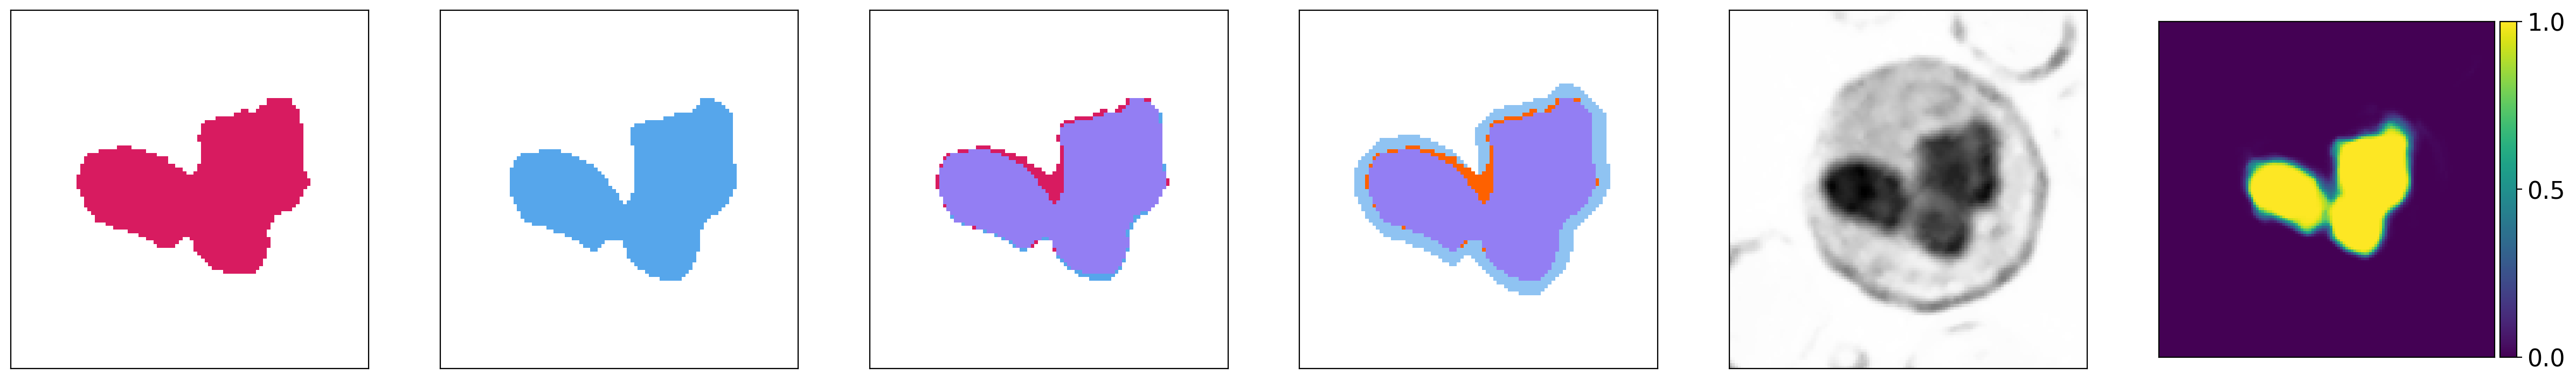

In [10]:
from typing import Optional
import numpy as np
import torch

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def fig_plot_margin_and_recovered(
    predicted_mask: np.ndarray,
    ground_truth_mask: np.ndarray,
    dilated_mask: np.ndarray,
    # margin: Optional[np.ndarray] = None,
    input_image: Optional[np.ndarray] = None,
    softprediction: Optional[np.ndarray] = None,
    plot_hard_margin: Optional[bool] = False,
    figsize: Optional[tuple] = None,
):
    if isinstance(predicted_mask, torch.Tensor):
        predicted_mask = predicted_mask.cpu().numpy()
    if isinstance(ground_truth_mask, torch.Tensor):
        ground_truth_mask = ground_truth_mask.cpu().numpy()
    if isinstance(dilated_mask, torch.Tensor):
        dilated_mask = dilated_mask.cpu().numpy()

    nplots = 4
    if input_image is not None:
        nplots += 1
    if softprediction is not None:
        nplots += 1

    margin = np.logical_xor(dilated_mask, predicted_mask)

    ## for readability in paper, crop the image.
    ## DANGER: assumes there is nothing going on in this region
    crop = 15
    ground_truth_mask = ground_truth_mask[crop:-crop, crop:-crop]
    predicted_mask = predicted_mask[crop:-crop, crop:-crop]
    dilated_mask = dilated_mask[crop:-crop, crop:-crop]
    margin = margin[crop:-crop, crop:-crop]

    ## do not crop input image, soft pred
    # if input_image is not None:
    #     input_image = input_image[crop:-crop, crop:-crop]

    recovered = np.where(
        (ground_truth_mask == 1) & (predicted_mask == 0) & (dilated_mask == 1), 1, 0
    )
    not_recovered = np.where(
        (ground_truth_mask == 1) & (predicted_mask == 0) & (dilated_mask == 0), 666, 0
    )

    if recovered.sum() == 0:
        print("No pixels were recovered")
        # return

    recovered_rgba = np.zeros((*recovered.shape, 4))
    # (X,X,X,1) for 1 with full opacity
    recovered_rgba[recovered == 1] = [1, 0, 0, 1]
    recovered_rgba[recovered == 0] = [0, 0, 0, 0]  # Transparent for value 0
    recovered_rgba[not_recovered == 666] = [0, 100 / 255, 0, 1]

    if plot_hard_margin:
        margin = np.where(margin > 0, 1, 0)

    figsize = (5 * nplots, 6)
    fig, axes = plt.subplots(1, nplots, figsize=figsize, dpi=200)

    ## === (1) Ground-truth mask
    gt_color = np.array((216, 27, 96)) / 255
    gt_rgba = np.zeros((*ground_truth_mask.shape, 4))
    gt_rgba[ground_truth_mask == 1] = [gt_color[0], gt_color[1], gt_color[2], 1]
    gt_rgba[ground_truth_mask == 0] = [1, 1, 1, 1]  # White for value 0

    axes[0].imshow(gt_rgba, interpolation="none")
    # axes[0].set_title("Ground-truth mask")
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    ## === (2) Predicted mask
    pred_color = np.array((30, 136, 229)) / 255
    pred_rgba = np.zeros((*predicted_mask.shape, 4))
    pred_rgba[predicted_mask == 1] = [pred_color[0], pred_color[1], pred_color[2], 0.75]
    pred_rgba[predicted_mask == 0] = [1, 1, 1, 1]  # White for value 0

    axes[1].imshow(pred_rgba, interpolation="none")
    # axes[1].set_title("Predicted mask")
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    ## === (3) Intersection of gt and pred: intersection in true_pos_color, the others as gt or pred respectively
    true_pos_color = np.array((120, 94, 240)) / 255
    intersection_rgba = np.zeros((*ground_truth_mask.shape, 4))
    intersection_rgba[(ground_truth_mask == 1) & (predicted_mask == 1)] = [
        true_pos_color[0],
        true_pos_color[1],
        true_pos_color[2],
        0.8,
    ]
    # false negative in gt_color
    intersection_rgba[(ground_truth_mask == 1) & (predicted_mask == 0)] = [
        gt_color[0],
        gt_color[1],
        gt_color[2],
        1,
    ]
    # false positive in pred_color
    intersection_rgba[(ground_truth_mask == 0) & (predicted_mask == 1)] = [
        pred_color[0],
        pred_color[1],
        pred_color[2],
        0.75,
    ]

    axes[2].imshow(intersection_rgba, interpolation="none")
    # axes[2].set_title("Intersection")
    axes[2].set_xticks([])
    axes[2].set_yticks([])

    ## === (4) Dilated mask:
    ## pred_mask in "gainsboro", margin in pred_color with alpha=0.5, recovered in orange with hatching
    recov_color = np.array((254, 97, 0)) / 255
    dilated_rgba = np.zeros((*dilated_mask.shape, 4))
    dilated_rgba[margin == 1] = [pred_color[0], pred_color[1], pred_color[2], 0.5]
    dilated_rgba[recovered == 1] = [recov_color[0], recov_color[1], recov_color[2], 1]
    # dilated_rgba[predicted_mask == 1] = [0.86, 0.86, 0.86, 1]
    dilated_rgba[predicted_mask == 1] = [
        true_pos_color[0],
        true_pos_color[1],
        true_pos_color[2],
        0.8,
    ]

    axes[3].imshow(dilated_rgba, interpolation="none")
    # axes[3].set_title("Dilated mask")
    axes[3].set_xticks([])
    axes[3].set_yticks([])

    ## if input_image is not None, plot it
    if input_image is not None:
        axes[4].imshow(input_image, cmap="Greys_r", interpolation="none")
        # axes[4].set_title("Input image")
        axes[4].set_xticks([])
        axes[4].set_yticks([])
        # axes[4].set_xlabel("Input image")
        ## if softprediction is not None, plot it
        if softprediction is not None:
            im = axes[5].imshow(softprediction, cmap="viridis", interpolation="none")
            axes[5].set_xticks([])
            axes[5].set_yticks([])
            divider = make_axes_locatable(axes[5])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = fig.colorbar(im, cax=cax, orientation="vertical")
            cbar.ax.tick_params(
                labelsize=16
            )  # Increase the font size of the colorbar labels
            cbar.set_ticks([0, 0.5, 1])  # Set the ticks to 0, 0.5, and 1
            # cbar.set_label('Color Intensity')

        plt.show()

        # Save individual subplots
        fig_filenames = [
            "figures/wbc_nc_margin_01_gt.png",
            "figures/wbc_nc_margin_02_pred.png",
            "figures/wbc_nc_margin_03_intersection.png",
            "figures/wbc_nc_margin_04_dilated.png",
            "figures/wbc_nc_margin_05_input.png",
            "figures/wbc_nc_margin_06_soft_prediction.png",
        ]
        for i, ax in enumerate(axes):
            extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(
                fig_filenames[i],
                bbox_inches=extent.expanded(1.025, 1.025),
                pad_inches=0.08,
                dpi=200,
            )

        # Save the last figure with the colorbar
        extent = axes[5].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(
            "figures/wbc_nc_margin_06_soft_prediction_with_colorbar.png",
            bbox_inches=extent.expanded(
                1.5, 1.10
            ),  # Adjust the expansion to include the colorbar
            pad_inches=0.08,
            dpi=200,
        )


fig_plot_margin_and_recovered(
    binpred[0],
    bintruth[0],
    dilated_mask_fixed,
    input_image=calib_images[idx_][0],
    softprediction=softpred[0],
)

#### Variable-size disk as structuring element

Instead of repeating dilations incrementally, on can obtain a similar results modifying the radius of the structuring element used for dilations.

Computationally, it should be worse than fixed-size for big radii: a naive implementation requires a number a computations that grows quadratically with the size (H x W) of the structuring element.

For binary dilations (our case), one can use a convolution followed by a max: this can be a good option if working directly with torch and tensors; with large images, we could expect comp. gains via gpus.

nc_variable = 4


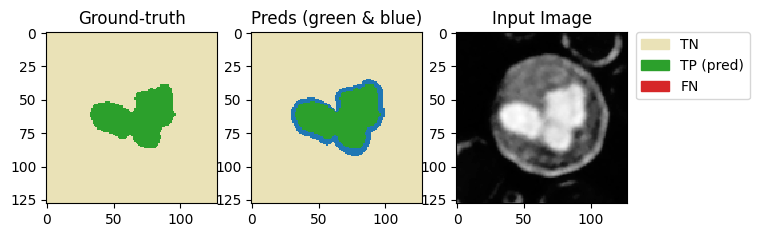

 ---  VARIA: n. added px = 820, stretch = 1.4792518994739918


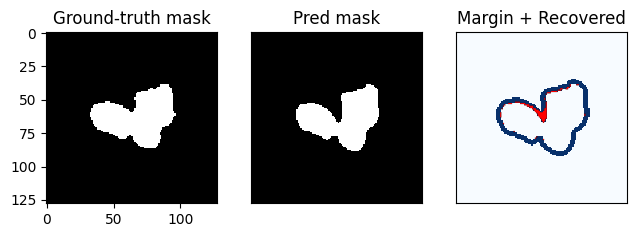

In [11]:
## 2. Variable disk
nc_variable = dilation_score_variable_disk(
    gt_mask_=bintruth[0],
    pred_mask_=binpred[0],
    se_params_=se_params,
    coverage_threshold=cov_threshold,
)
print(f"{nc_variable = }")

dilated_mask_variable = operator_dilation_disk_radius(
    binpred[0], nc_variable, se_params
)

visualize_false_negatives(calib_images[idx_][0], bintruth[0], dilated_mask_variable)

metrics = dilation_metrics(dilated_mask_variable, binpred[0])
print(f" ---  VARIA: n. added px = {metrics[0]}, stretch = {metrics[1]}")
plot_margin_and_recovered(binpred[0], bintruth[0], dilated_mask_variable)

---

## Conformal loop: compute scores and quantiles

Conformal prediction (CP) is usually presented as a predictive method to build statistically valid prediction sets (or intervals) that will contain, with high probability, the true value of a target $Y$ being predicted by some ML model as $\hat{Y} = \hat{f}(X)$; the features X could be tabular data, images, etc.

However, we have another useful piece of information: the actual errors (nonconformity scores), their size, their distribution.
CP can also be used as a diagnostic tool: the users choose a score (or make their own), a tolerable risk level, and then they could:
- compare several architectures, trained on the same data: the one with the smallest scores (and prediction set) could be preferable to another with slightly better performance metrics (precision, mAP, etc.)
- interpret the errors: in production, how and where the model errs.
- interpret the size and shape of the prediction set: for regression or classification, this is the width and cardinality or pred. sets. For segmentation or object detection, this could be the size of the conformal margins, etc.

### The Split conformal prediction procedure:


1. Setup a pre-trained model, or train your own
2. setup a parametrized prediction set (hence a nonconformity score): $C_{\lambda}(X)$
3. Fix an acceptable error probability $\alpha$, also called "risk", "nominal error", "nominal risk", etc.
- can be written as $\epsilon$
- $1-\alpha$ is known as the (nominal) coverage of our conformalized predictor: with confidence $1-\alpha$, the sets will contain the true value of $Y$ (this is a frequentist object, so some care is necessary when building and interpreting prediction sets).
4. Get some **production-like** data $D_{\text{cal}}$, often called "calibration data": labeled data, not used during training, that represents the data distribution fed into your model when deployed in production
5. Compute nonconformity scores $r(X,Y)$ on $D_{\text{cal}}$
6. Compute the **adjusted** empirical quantile of order $(1-\alpha)(1+\frac{1}{n})$
- sort the scores in ascending order
- compute the quantile as $\hat{\lambda_{\alpha}} = \lceil (1 - \alpha)(n+1) \rceil$-th largest score
7. At inference, compute $C_{\hat{\lambda}}(X)$ by plugging $\hat{\lambda_{\alpha}}$ into $C_{\lambda}(X)$ 

Note that $C_{\lambda}(X)$ can be *any* prediction set, as long as the they are nested:
- $C_{\lambda_0}(X) \subseteq C_{\lambda_1}(X)$ for all $\lambda_0 \leq \lambda_1$
- as $\lambda$ grows, so does the prediction set. 
- In the worst-case scenario, we can retrieve the trivial set $C_{\lambda_{max}}(X) = \mathcal{Y}$

### Visualize margin: use a gradient to show successive dilations and recovered pixels

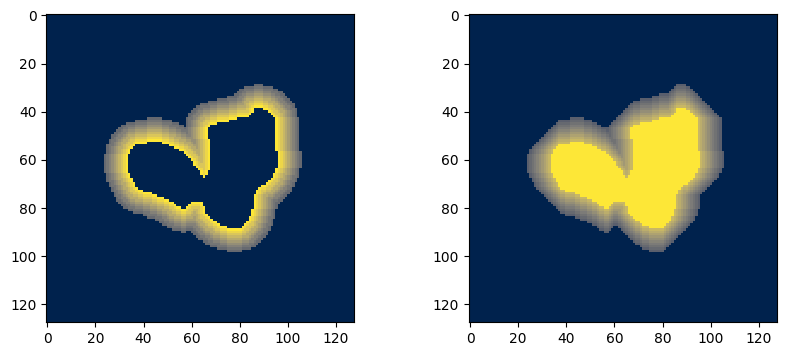

In [12]:
from consema.plots import margin_gradient_visu

margin_var = margin_gradient_visu(
    binpred[0], "variable_disk", 10, None, False, se_params
)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(margin_var, cmap="cividis", interpolation="none")
margin_fixed = margin_gradient_visu(binpred[0], "fixed_disk", 10, None, True, se_params)
ax[1].imshow(margin_fixed, cmap="cividis", interpolation="none")
plt.show()

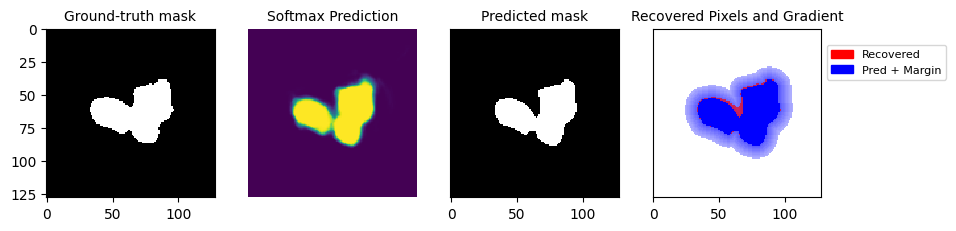

In [13]:
from matplotlib.patches import Patch
from consema.conformal import recovered_pixels_bin_array

_grad = margin_gradient_visu(binpred[0], "variable_disk", 10, 20, True, se_params)

# Assuming _grad is your H x W array
H, W = _grad.shape
rgba_image = np.zeros((H, W, 4), dtype=np.uint8)  # Create an RGBA array

# Normalize the gradient to the range [0, 1]
normalized_grad = _grad / np.max(_grad)

# Set all pixels that are non-zero in the recovered mask to red with full opacity
recovered = recovered_pixels_bin_array(bintruth[0], binpred[0], dilated_mask_variable)

# Define blending factor and colors
alpha_blend = 0.7  # Controls red intensity (0 = no red, 1 = fully red)

# Assign colors: white for zeros, blue for non-zero entries
nonmargin_indices = np.where(_grad > 0)
rgba_image[..., 0] = (1 - normalized_grad) * 255  # Red channel
rgba_image[..., 1] = (1 - normalized_grad) * 255  # Green channel
rgba_image[..., 2] = 255  # Blue channel
rgba_image[..., 3] = (normalized_grad * 255).astype(
    np.uint8
)  # Alpha channel (transparency)

# Blend red for recovered pixels
recovered_indices = np.where(recovered == 1)
rgba_image[recovered_indices] = (
    alpha_blend * np.array([255, 0, 0, 255])  # Red with full opacity
    + (1 - alpha_blend) * rgba_image[recovered_indices]
).astype(np.uint8)

# Visualize the RGBA image
fig, ax = plt.subplots(1, 4, figsize=(10, 5))

# Plot ground truth mask on the left
ax[0].imshow(bintruth[0], cmap="gray", interpolation="none")
ax[0].set_title("Ground-truth mask", fontsize=10)
# ax[0].axis("off")

# Plot softmax prediction
ax[1].imshow(softpred[0], cmap="viridis", interpolation="none")
ax[1].set_title("Softmax Prediction", fontsize=10)
ax[1].axis("off")

# plot hard predicted mask
ax[2].imshow(binpred[0], cmap="gray", interpolation="none")
# ax[2].imshow(binpred[0], cmap="Greens", interpolation="none")
ax[2].set_title("Predicted mask", fontsize=10)
ax[2].get_yaxis().set_visible(False)

# Plot RGBA image on the right
ax[3].imshow(rgba_image, interpolation="none")
ax[3].set_title("Recovered Pixels and Gradient", fontsize=10)
ax[3].get_yaxis().set_visible(False)

legend_elements = [
    Patch(facecolor="red", edgecolor="red", label="Recovered"),
    Patch(facecolor="blue", edgecolor="blue", label="Pred + Margin"),
]

ax[3].legend(
    handles=legend_elements, fontsize=8, loc="center left", bbox_to_anchor=(1, 0.8)
)
plt.show()

### Setup conformalizer

In [20]:
from benchmarkerie.models import UniversegInferenceWrap

inferencer = UniversegInferenceWrap(
    model=model,
    support_images=support_images,
    support_labels=support_labels,
    device=device,
    return_numpy=True,
)

### Setup conformal parameters
- `covratio` $\in (0,1)$ (coverage ratio): how many ground-truth pixels must be covered in each image to be considered a success
- `alpha` $ \in (0,1)$ (nominal risk): on average, how many inferences can be wrong (but we don't say by how much)

During conformalization, the nonconformity scores tell
- how many dilations, or 
- how big the structuring element (e.g. disk), or
- which threshold $\in (0,1)$

was necessary to achieve the specified `covratio`. If `covratio = 1`, then 100% of the ground-truth pixels must be captured.

In [66]:
# covratio = 0.99999
covratio = 0.999
# covratio = 0.9
# covratio = 1.0

# alpha = 0.90
# alpha = 0.50
alpha = 0.10
# alpha = 0.07
# alpha = 0.80  # BAD just for testing

score_funcs = ["fixed_disk", "variable_disk", "thresholding"]
chosen_nc_score = score_funcs[0]
# chosen_nc_score = score_funcs[1]
# chosen_nc_score = score_funcs[2]

#### Compute nonconformity scores

In [67]:
print(f" --- n calibration points: {len(data_calib)}")

cpred = Conformalizer(
    inferencer=inferencer,
    nonconformity_function_name=chosen_nc_score,
    structuring_element_params=se_params,
)

confo_resu = cpred.compute_nonconformity_scores(data_calib, covratio)

 --- n calibration points: 50


/home/luca.mossina/projects/vision/consema/src/benchmarkerie/models.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, label = torch.tensor(image).to(self.device), torch.tensor(label).to(


#### Compute conformalizing empirical quantile

 --- Required coverage ratio = 0.999
 --- Probability of succes on test = 0.9
 --- Chosen nonconformity score: fixed_disk


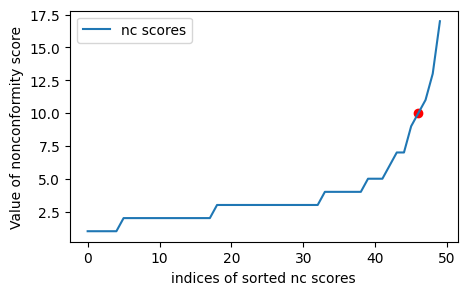

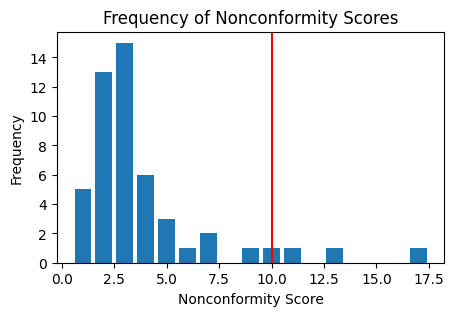

In [68]:
print(f" --- Required coverage ratio = {covratio}")
print(f" --- Probability of succes on test = {1 - alpha}")
print(f" --- Chosen nonconformity score: {chosen_nc_score}")
# cpred.plot_nc_scores(confo_resu["nonconformity"], alpha)
cpred.plot_nc_scores(alpha_risk=alpha)
cpred.plot_nc_scores_frequency(alpha=alpha)

#### Metrics of conformal prediction sets on test data

In [69]:
print(f" --- Required coverage ratio = {covratio}")
print(f" --- Probability of succes on test = {1 - alpha}")
print()
test_preds = cpred.test_inferences(data_test)
test_results = cpred.test_conformalization(test_preds, alpha, covratio)

 --- Required coverage ratio = 0.999
 --- Probability of succes on test = 0.9



In [70]:
empirical_coverage = np.mean(test_results.conformal_tests)
empirical_covratio = np.mean(test_results.empirical_covratios)
empirical_avg_add_pixels = np.mean(test_results.added_pixels)
empirical_avg_stretch = np.mean(test_results.stretch_factors)

print(
    f" --- cov : {empirical_coverage:.4f} vs nominal : {1-alpha}, for num elements: {len(test_results.conformal_tests)}"
)
print(f" --- {empirical_covratio = :.4f} -vs- {covratio = :.4f}")
print(f" --- {empirical_avg_add_pixels = :.4f}")
print(f" --- {empirical_avg_stretch = :.4f}")

 --- cov : 1.0000 vs nominal : 0.9, for num elements: 40
 --- empirical_covratio = 1.0000 -vs- covratio = 0.9990
 --- empirical_avg_add_pixels = 1942.0250
 --- empirical_avg_stretch = 1.9848
